In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)
np.random.seed

<function RandomState.seed>

In [3]:
nsample = 50
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e 
X = X[:,[0,1]]
X

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.40816327],
       [ 1.        ,  0.81632653],
       [ 1.        ,  1.2244898 ],
       [ 1.        ,  1.63265306],
       [ 1.        ,  2.04081633],
       [ 1.        ,  2.44897959],
       [ 1.        ,  2.85714286],
       [ 1.        ,  3.26530612],
       [ 1.        ,  3.67346939],
       [ 1.        ,  4.08163265],
       [ 1.        ,  4.48979592],
       [ 1.        ,  4.89795918],
       [ 1.        ,  5.30612245],
       [ 1.        ,  5.71428571],
       [ 1.        ,  6.12244898],
       [ 1.        ,  6.53061224],
       [ 1.        ,  6.93877551],
       [ 1.        ,  7.34693878],
       [ 1.        ,  7.75510204],
       [ 1.        ,  8.16326531],
       [ 1.        ,  8.57142857],
       [ 1.        ,  8.97959184],
       [ 1.        ,  9.3877551 ],
       [ 1.        ,  9.79591837],
       [ 1.        , 10.20408163],
       [ 1.        , 10.6122449 ],
       [ 1.        , 11.02040816],
       [ 1.        ,

In [4]:
mod_wls = sm.WLS(y, X, weights=1./(w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            WLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     613.2
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           5.44e-29
Time:                        12:28:52   Log-Likelihood:                -51.136
No. Observations:                  50   AIC:                             106.3
Df Residuals:                      48   BIC:                             110.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2469      0.143     36.790      0.0

In [6]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[5.24256099 0.43486879]
[5.24685499 0.44658241]


In [7]:
se = np.vstack([[res_wls.bse], [res_ols.bse], [res_ols.HC0_se], 
                [res_ols.HC1_se], [res_ols.HC2_se], [res_ols.HC3_se]])
se = np.round(se,4)
colnames = ['x1', 'const']
rownames = ['WLS', 'OLS', 'OLS_HC0', 'OLS_HC1', 'OLS_HC3', 'OLS_HC3']
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

          x1   const 
---------------------
WLS     0.1426  0.018
OLS     0.2707 0.0233
OLS_HC0  0.194 0.0281
OLS_HC1  0.198 0.0287
OLS_HC3 0.2003  0.029
OLS_HC3  0.207   0.03
---------------------


In [11]:
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb,X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

In [9]:
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

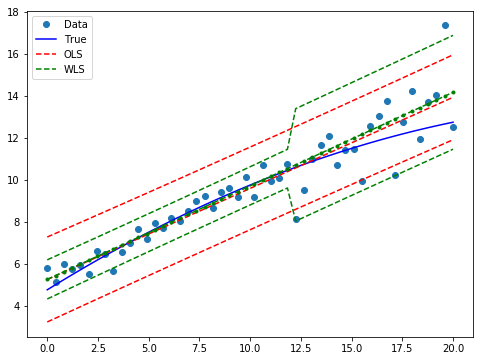

In [12]:
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="OLS")
ax.plot(x, iv_l_ols, 'r--')
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_u, 'g--', label="WLS")
ax.plot(x, iv_l, 'g--')
ax.legend(loc="best");

In [13]:
resid1 = res_ols.resid[w==1.]
var1 = resid1.var(ddof=int(res_ols.df_model)+1)
resid2 = res_ols.resid[w!=1.]
var2 = resid2.var(ddof=int(res_ols.df_model)+1)
w_est = w.copy()
w_est[w!=1.] = np.sqrt(var2) / np.sqrt(var1)
res_fwls = sm.WLS(y, X, 1./((w_est ** 2))).fit()
print(res_fwls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            WLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     646.7
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           1.66e-29
Time:                        12:45:35   Log-Likelihood:                -50.716
No. Observations:                  50   AIC:                             105.4
Df Residuals:                      48   BIC:                             109.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2363      0.135     38.720      0.0